## ***InvestInpect*** - 
 The pulse of your portfolio. A stock investment portfolio tracker and optimizer. By using our user friendly interface to enter your current stocks, and the shares of which you hold, you can see the real time prices and value of your portfolio. Then you can perform quantative analysis on your investments in several ways and forecasting different probabilities. Weight our your risks and ensure your making the best financial decision possible.

In [13]:
# Creating the GUI interface using tkinter
# Import need libraries
import tkinter as tk
from tkinter import messagebox
from tkinter import ttk
import pandas as pd # Import pandas module
import yfinance as yf

# Defining the object of and attributes of the GUI
class StockPortfolioTracker:
    def __init__(self, root):
        self.root = root
        self.root.title("Investinspect")  # Set the window title
        self.stocks = {}
        
        # Create title label
        #self.title_label = tk.Label(root, text="The Pulse of your Investment Portfolio", font=('Arial', 17))
        #self.title_label.grid(row=0, column=0, columnspan=2)
        
        # Create labels
        self.stock_label = tk.Label(root, text="Stock Symbol:")
        self.stock_label.grid(row=0, column=0)
        self.shares_label = tk.Label(root, text="Number of Shares:")
        self.shares_label.grid(row=1, column=0)
        self.price_label = tk.Label(root, text="Current Price:")
        self.price_label.grid(row=2, column=0)
        self.price = 0
        # Create entry fields
        self.stock_entry = tk.Entry(root)
        self.stock_entry.grid(row=0, column=1)
        self.shares_entry = tk.Entry(root)
        self.shares_entry.grid(row=1, column=1)
        # these lines were the fields for the user to enter the current amount of their stock
        #self.price_entry = tk.Entry(root)
        #self.price_entry.grid(row=2, column=1)
        
        # Replaced the entry field to automatically populate the label with the real time current price  
        # from yfinance
        self.price_label = ttk.Label(master = root, text = self.price, font = 'Calibri 11')
        self.price_label.grid(row=2, column=1)
        self.price_entry = float(self.price_label.cget("text"))

        # Create button that adds the stock and the quantity to the listbox
        self.button = tk.Button(root, text="Add Stock", command=self.add_stock)
        self.button.grid(row=3, column=0, columnspan=2)

        # Create listbox to display stocks
        self.listbox = tk.Listbox(root)
        self.listbox.grid(row=4, column=0, columnspan=2)

        # Create label to display total portfolio value
        self.total_label = tk.Label(root, text="")
        self.total_label.grid(row=5, column=0, columnspan=2)

        # Create empty DataFrame to store the data
        self.df = pd.DataFrame(columns=["Stock Symbol", "Number of Shares", "Current Price"]) # Add this line

# Function that contains the 'stock' details
    def add_stock(self):
        # user inputs the stock 
        stock = self.stock_entry.get()
        # user inputs the amount of shares
        shares = float(self.shares_entry.get())
        # Fetching the Real time prices from yahoo finance
        ystock = yf.Ticker(stock)
        self.price = ystock.info.get('currentPrice')
       
        #my original code -- user had to add the current price manually
        #price = float(self.price_entry.get())
        
        # Calculates the value of the stock determined by the amount of shares
        self.stocks[stock] = self.price * shares

        # Clear the entry fields
        self.stock_entry.delete(0, tk.END)
        self.shares_entry.delete(0, tk.END)
        #self.price_entry.delete(0, tk.END)

        # Update listbox and total portfolio value
        self.update_listbox()
        self.update_total()

        # Append the data to the DataFrame
        #self.df = self.df.append({"Stock Symbol": stock, "Number of Shares": shares, "Current Price": price}, ignore_index=True) # Add this line
        self.df = pd.concat([self.df, pd.DataFrame({"Stock Symbol": 
                                                    stock, "Number of Shares": 
                                                    shares, "Current Price": 
                                                    self.price}, 
                                                   index=[0])]) 
                           
        # Save the table to a CSV file
        self.df.to_csv("stock_data.csv", index=False) # Add this line
        self.price_label.config(text=self.price)       
        messagebox.showinfo("Success", "Stock added successfully!")

    def update_listbox(self):
        self.listbox.delete(0, tk.END)
        for stock, value in self.stocks.items():
            self.listbox.insert(tk.END, f"{stock}: ${value}")

    def update_total(self):
        total_value = sum(self.stocks.values())
        total_value = round(total_value, 2)    
        self.total_label.config(text=f"Total Portfolio Value: ${total_value}")
        
        
    
        
root = tk.Tk()
app = StockPortfolioTracker(root)
root.mainloop()

In [19]:
# Importing the rest of the liraries for use of data analysis
from pathlib import Path
import yfinance as yf
import pandas as pd
import numpy as np
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt
import math
import hvplot.pandas
from MCForecastTools import MCSimulation

# Ignoring warnings 
import warnings
warnings.filterwarnings('ignore')

# Set and read the CSV file from Path
portfolio_df = pd.read_csv(Path("stock_data.csv"))

### Creating a new DataFrame to store the stocks and shares and visualizing in a pie chart

Total Portfolio Value: 8597.27


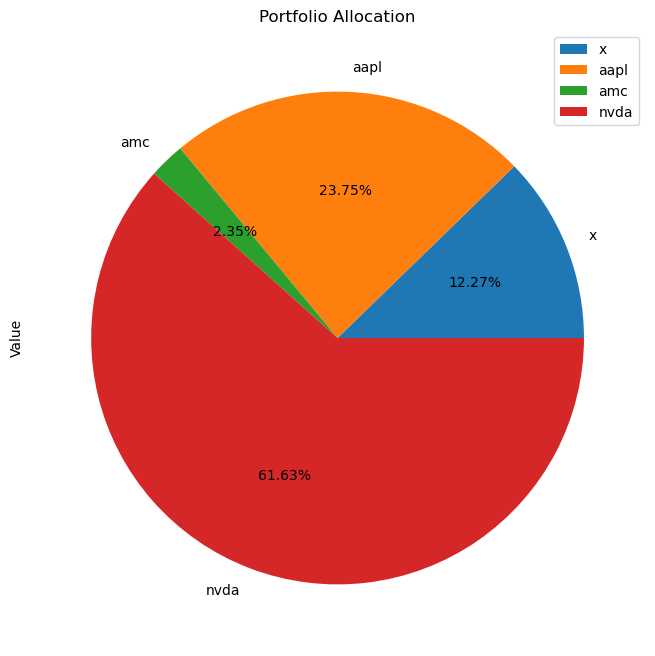

In [20]:
portfolio_df['Stock Holding Value'] = portfolio_df['Current Price'] * portfolio_df['Number of Shares']

total_portfolio_value = portfolio_df['Stock Holding Value'].sum().round(2)
print("Total Portfolio Value:", total_portfolio_value)

portfolio_df = portfolio_df.set_index('Stock Symbol')
each_stock_value = pd.DataFrame((portfolio_df['Current Price'] * portfolio_df['Number of Shares']).round(2))
percentage_of_portfolio = ((each_stock_value / total_portfolio_value) * 100).round(2)

portfolio_summary = pd.concat([each_stock_value, percentage_of_portfolio], axis=1)
portfolio_summary.columns = ['Value', 'Percentage']
portfolio_summary.plot.pie(y='Value', 
                           autopct='%1.2f%%', 
                           title="Portfolio Allocation", 
                           figsize=(8, 8))
plt.legend(loc='upper right')

# Save plot in the images folder.
plt.savefig('gui_images/portfolio_allocation.png')

In [21]:
# Verifing the new dataframe
portfolio_df

,Number of Shares,Current Price,Stock Holding Value
Stock Symbol,,,
x,22.0,47.96,1055.12
aapl,11.0,185.64,2042.04
amc,33.0,6.11,201.63
nvda,11.0,481.68,5298.48


### Pulling the historical data on the chosen stocks for the last 5 years 

In [23]:
# Reset the index and turn ticker names into upper case letter.
portfolio_df = portfolio_df.reset_index()
portfolio_df['Stock Symbol'] = portfolio_df['Stock Symbol'].str.upper()


# Run if statement to get stock tickers and number of shares.
if 'Stock Symbol' in portfolio_df.columns:
    portfolio_tickers = portfolio_df['Stock Symbol']
if 'Number of Shares' in portfolio_df.columns:
    stock_shares = portfolio_df['Number of Shares']

# Convert stock tickers and number of shares into list .
portfolio_tickers =(portfolio_tickers).tolist()
stock_shares =(stock_shares).tolist()

# Iterates through each stock tickers, download data for each stock for defiend period and 
# store it in historical_data
historical_data = {}
for stock_symbol in portfolio_tickers:
    stock_data = yf.download(stock_symbol, period="5y")
    historical_data[stock_symbol] = stock_data['Close']

# Convert historical_data to a DataFrame
historical_data_df = pd.DataFrame(historical_data)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


### Puilling the historical data of the s&p 500 for 5 years and combining with historical data of our chosen stocks.

In [24]:
# Fetch the closing data for Sp 500, Define period you wish to work with.
sp500_data = yf.download('^GSPC',  period="5y") 
sp500_closing_prices = sp500_data['Close']

# Convert to pandas DataFrame, Rename cloumn name to SP500.
sp500_closing_prices = pd.DataFrame(sp500_closing_prices)
sp500_closing_prices.columns = ['SP500']


#  Calculate daily retuns of the Market and drop na.
sp500_returns = sp500_closing_prices.pct_change().dropna()

# Convert historical data of portfolio to pandas DataFrame and Calculate daily retuns of portfolio and drop na. 
portfolio_returns = historical_data_df.pct_change().dropna()

# Combine market and portfolio returns to one DataFrame.
combined_returns = pd.merge(sp500_returns, portfolio_returns, on='Date')
combined_returns

[*********************100%%**********************]  1 of 1 completed


,SP500,X,AAPL,AMC,NVDA
Date,,,,,
2019-01-04,0.034336,0.100649,0.042689,0.036753,0.064068
2019-01-07,0.007010,0.005408,-0.002226,0.042836,0.052941
2019-01-08,0.009695,0.012225,0.019063,0.031870,-0.024895
2019-01-09,0.004098,0.006763,0.016982,-0.042553,0.019667
2019-01-10,0.004518,0.007198,0.003196,-0.015771,0.018586
...,...,...,...,...,...
2023-12-26,0.004232,0.007922,-0.002841,0.001639,0.009195
2023-12-27,0.001430,0.005378,0.000518,0.008183,0.002800
2023-12-28,0.000370,0.001029,0.002226,0.008117,0.002125


### Calculating the cumulative returns for the chosen stocks and the s&p500. Visualized with a line plot

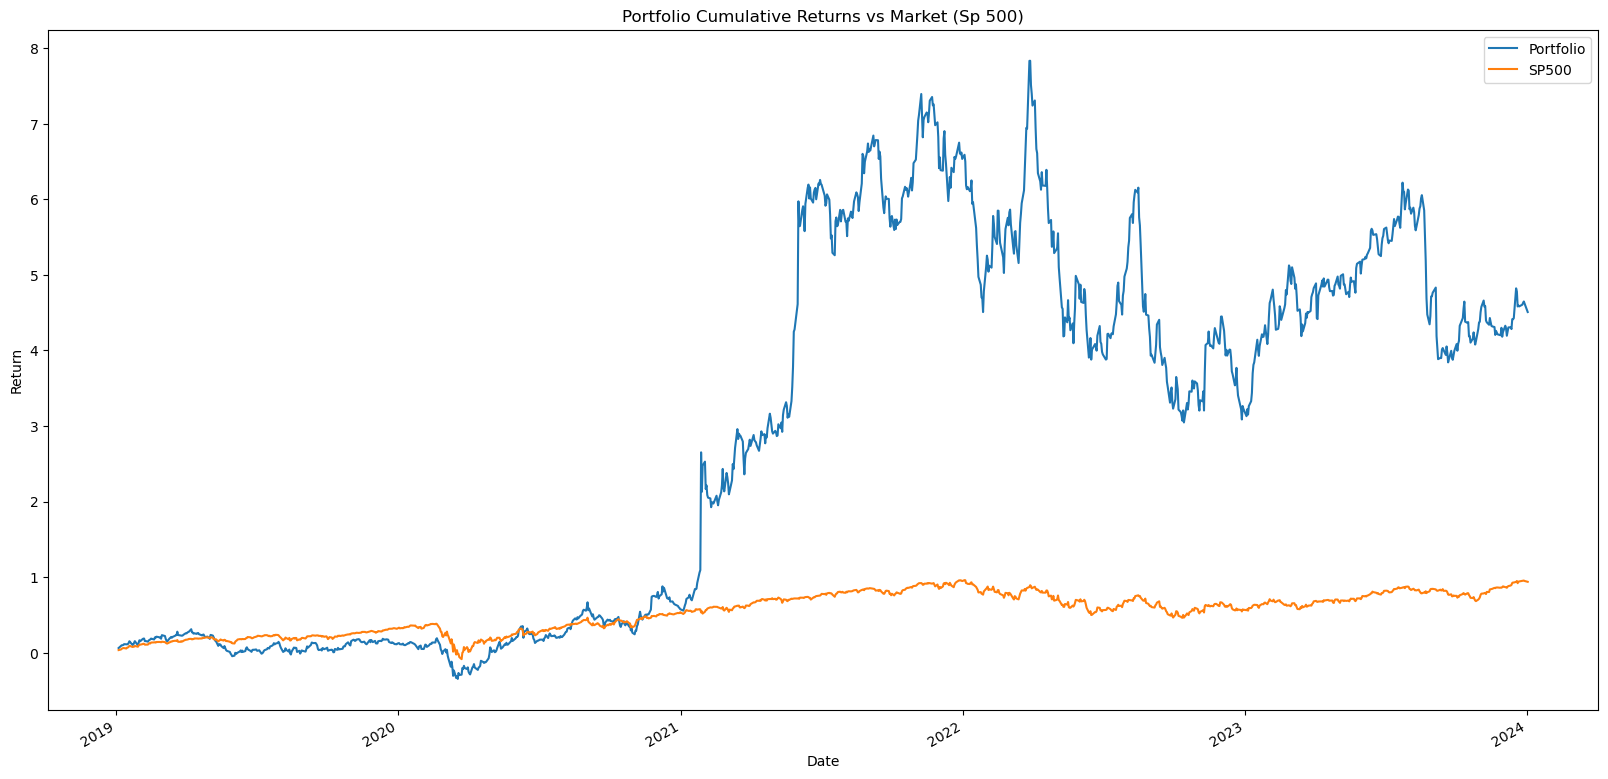

In [25]:
# Calculate the average returns of the portfolio and 
# cumulative returns of the portfolio and then plot it.
portfolio_average_returns = portfolio_returns.mean(axis=1)
portfolio_cumulative_returns = (1 + portfolio_average_returns).cumprod() - 1
ax = portfolio_cumulative_returns.plot(figsize=(20,10), 
                        ylabel='Return',
                        title='Portfolio Cumulative Returns vs Market (Sp 500)',
                        label='Portfolio',
                        legend=True)
# Calculate cumulative returns of th market and plot it against our portfolio.
spy500_cumulative_returns = (1 + sp500_returns).cumprod() - 1
spy500_cumulative_returns.plot(ax=ax, 
                               label='SP500', 
                               legend=True)

# Save plot in the images folder.
plt.savefig('gui_images/cumulative_returns.png')

### Calculating the returns of each individual stock

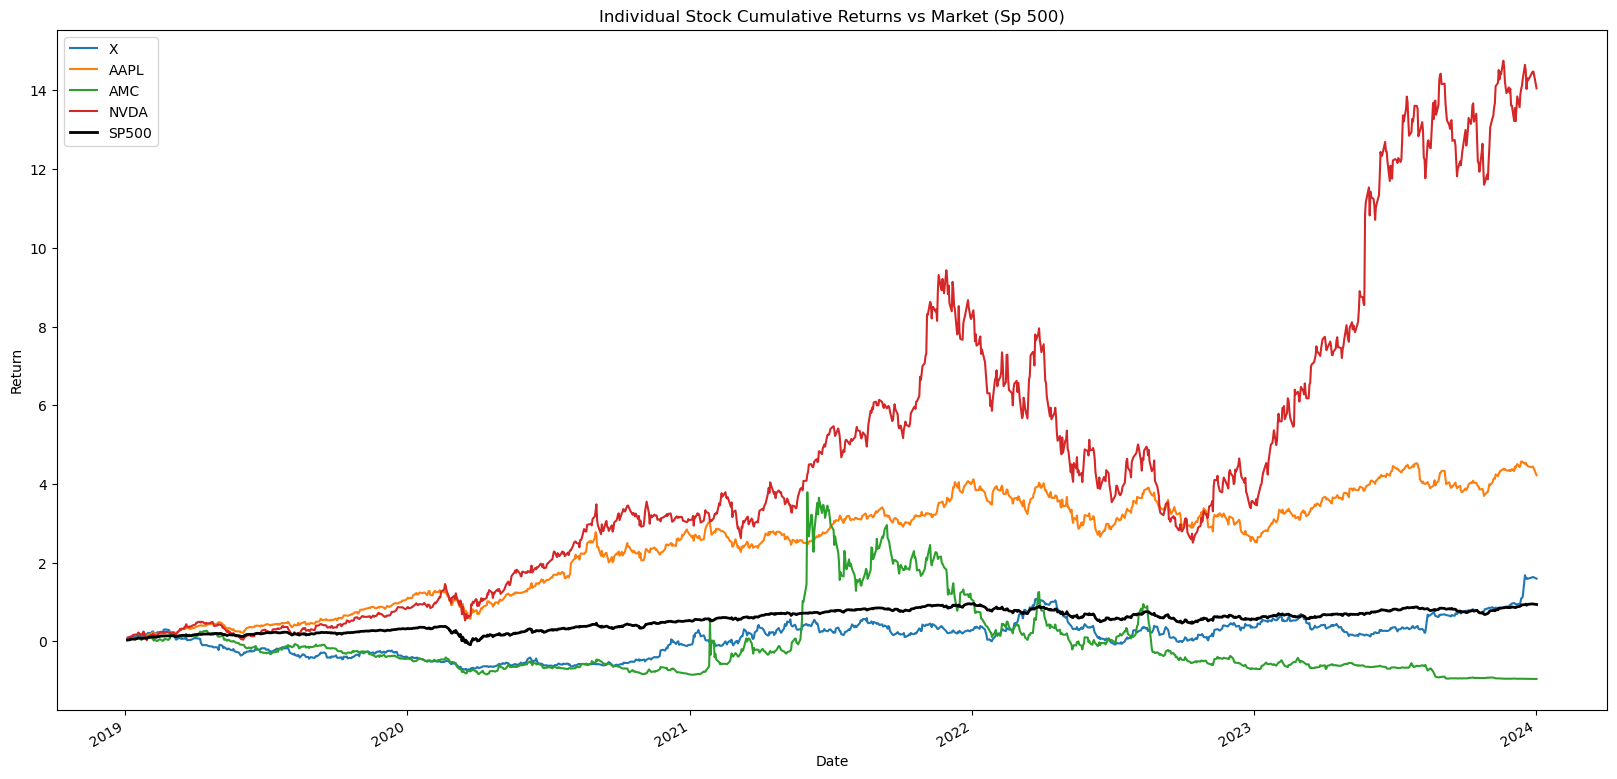

In [26]:
stock_cumulative_returns = (1 + portfolio_returns).cumprod() - 1
ax = stock_cumulative_returns.plot(figsize=(20,10), 
                        ylabel='Return',
                        title='Individual Stock Cumulative Returns vs Market (Sp 500)',
                        label='Portfolio',
                        legend=True)
spy500_cumulative_returns = (1 + sp500_returns).cumprod() - 1
spy500_cumulative_returns.plot(ax=ax, 
                               label='SP500', 
                               legend=True,
                               color='black', 
                               linewidth=2)
plt.savefig('gui_images/individual_cumulative_returns.png')

### Plotting the portfolio returns and the s&p500

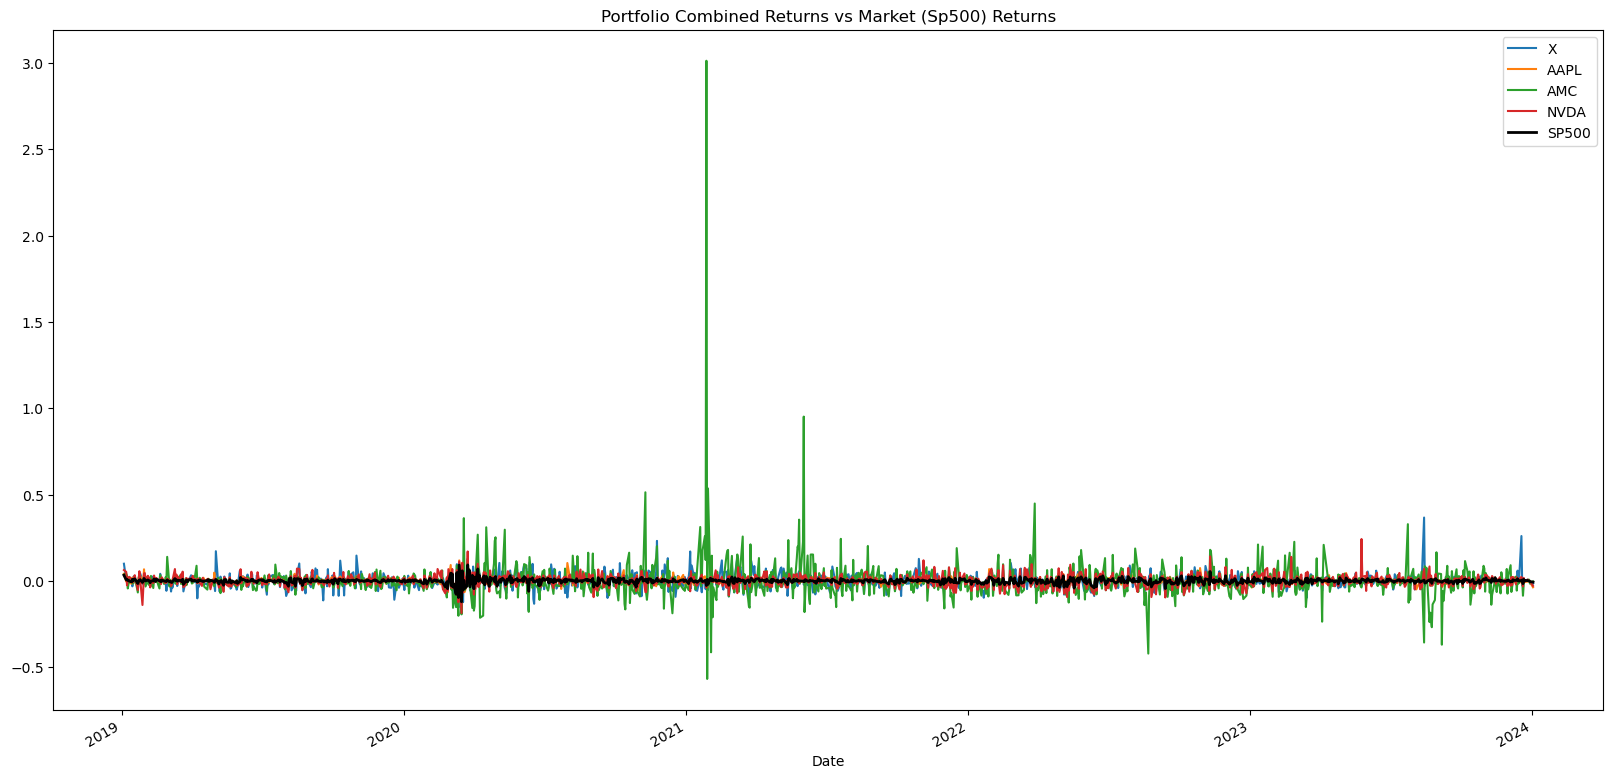

In [27]:
# Plot portfolio retuns and market retuns # Save plot in the images folder.
ax = portfolio_returns.plot(figsize=(20,10),
                       title='Portfolio Combined Returns vs Market (Sp500) Returns', 
                       legend=True)

sp500_returns.plot(ax=ax, label='SP500', 
                               legend=True,
                               color='black', 
                               linewidth=2) 

plt.savefig('gui_images/combined_returns.png')

### Plotting the BETA and visualzing with a line plot

<Axes: title={'center': 'Portfolio - Beta Trend'}, xlabel='Date'>

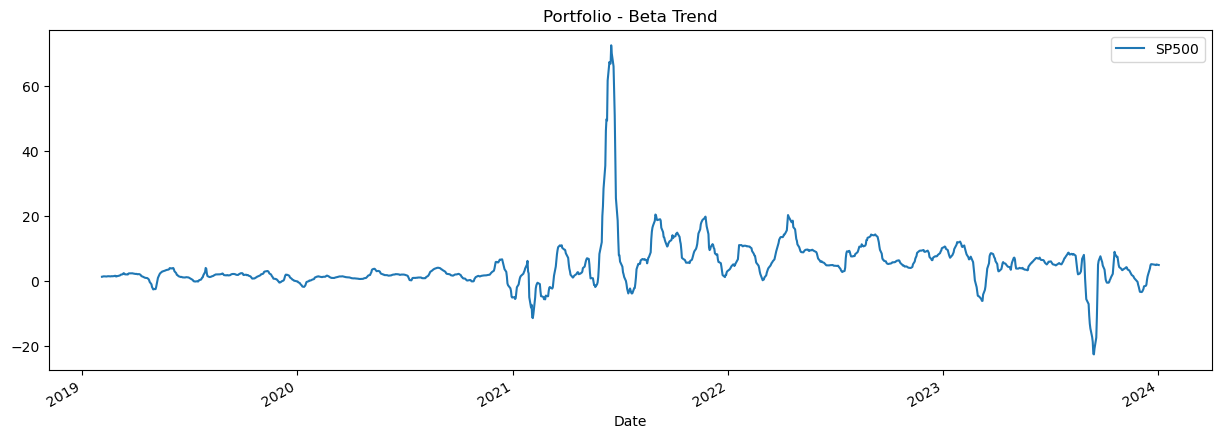

In [28]:
### Calculating the BETA and plotting the BETA trend
# Calculate covariance of a single portfolio
covariance_portfolio = portfolio_cumulative_returns.rolling(window=21).cov(spy500_cumulative_returns)
# Calculate variance of S&P 500
variance_sp500 = spy500_cumulative_returns.rolling(window=21).var()
# Computing beta
portfolio_beta = covariance_portfolio / variance_sp500
# Plot beta trend
portfolio_beta.plot(figsize=(15,5), title = "Portfolio - Beta Trend")

### Defining the risk free rate and calculating the excess returns, as well as the risks of the returns 

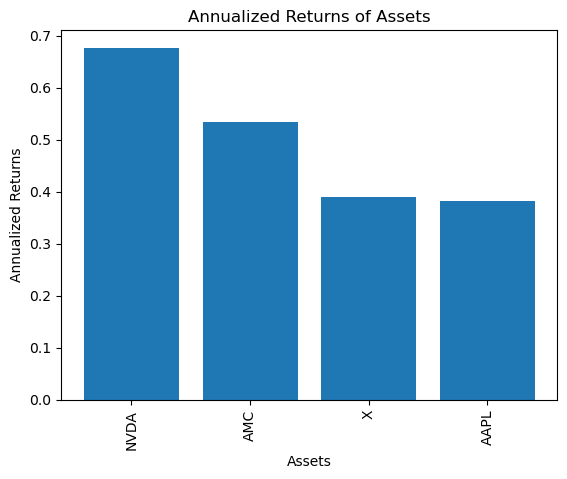

In [29]:
# define the risk free rate
risk_free_rate = 0.04/252 # annualized yield of 3-month Treasury bill divided by 252 trading days

# calculate the excess returns of each stock in the portfolio
excess_returns = portfolio_returns * stock_shares - risk_free_rate


# Calculate the annual returns
annual_daily_returns = portfolio_returns.mean() * 252
annual_excess_returns = excess_returns.mean() * 252

# Calculate the daily standard deviations
portfolio_returns_std = portfolio_returns.std()

# CAluculating the excess returns
excess_returns_std = excess_returns.std()


######### annual STD

# Calculate the annualized standard deviation (252 trading days)
stock_annualized_std = portfolio_returns_std * np.sqrt(252)
portfolio_annualized_std = excess_returns_std * np.sqrt(252)

# Calculate the stock risk
annual_stock_risk = portfolio_returns_std * math.sqrt(252)
annual_excess_risk = excess_returns_std * math.sqrt(252)

# Sorted the data in decending order
sorted_annual_returns = annual_daily_returns.sort_values(ascending=False)
sorted_annual_excess_returns = annual_excess_returns.sort_values(ascending=False)


# plot the sorted annualized returns of stock
plt.bar(sorted_annual_returns.index, sorted_annual_returns)
plt.ylabel("Annualized Returns")
plt.xlabel('Assets')

plt.xticks(rotation=90)
plt.title('Annualized Returns of Assets')
plt.savefig('gui_images/annualized_returns.png')

In [30]:
### plotting the excess returns of the portfolio

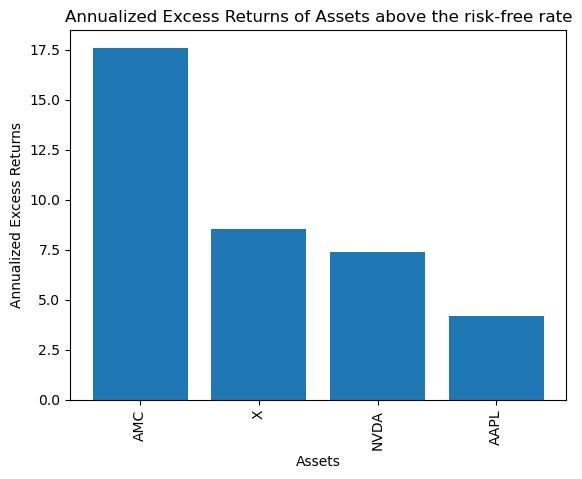

In [31]:
# Plot of the excess annual returns
# plot the sorted annualized returns of stock
plt.bar(sorted_annual_excess_returns.index, sorted_annual_excess_returns)
plt.ylabel("Annualized Excess Returns")
plt.xlabel('Assets')
plt.xticks(rotation=90)
plt.title('Annualized Excess Returns of Assets above the risk-free rate')
plt.savefig('gui_images/annualized_excess_returns.png')

### Creating a dataFrame of the risk and expected returns of our portfolio

In [33]:
# creat a dataframe to store the annual returns, annual risks, 
# annual excess returns and company ticker and new column for the ratio

risk_df = pd.DataFrame()
risk_df['Expected Annual Returns'] = annual_daily_returns
risk_df['Expected Annual Risk'] = annual_stock_risk
risk_df['Expected Annual Excess Returns'] = annual_excess_returns
risk_df['Stock'] = portfolio_tickers
risk_df['Ratio'] = risk_df['Expected Annual Returns'] / risk_df['Expected Annual Risk']

# show in decending order for the expected annual returns
risk_df.sort_values(by="Ratio", axis = 0, ascending=False, inplace=False)


,Expected Annual Returns,Expected Annual Risk,Expected Annual Excess Returns,Stock,Ratio
NVDA,0.676893,0.517107,7.405827,NVDA,1.309000
AAPL,0.382617,0.319668,4.168791,AAPL,1.196921
X,0.389578,0.636984,8.530711,X,0.611597
AMC,0.534127,1.873375,17.586180,AMC,0.285115


### Visualization of the risk to profit with a scatter plot
This visualization helps to show what stocks have a high risk and the expected returns that are possible. Easy to tell which stocks are to volatile with low returns.

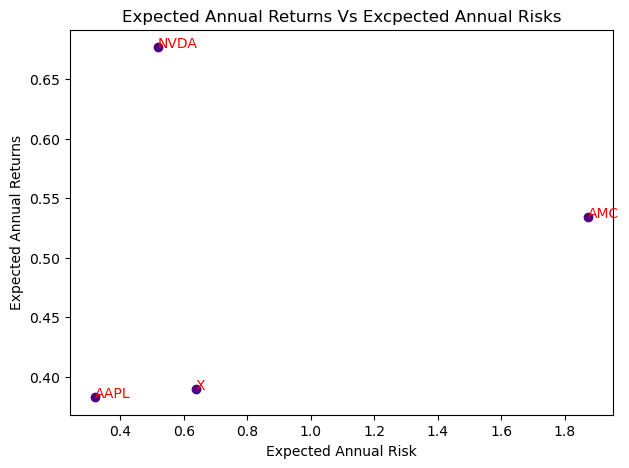

In [35]:
# visually show the ecpected annual returns vs the expected annual risk
risk_df.hvplot.bar()

fig, ax = plt.subplots(figsize=(7,5))
plt.title('Expected Annual Returns Vs Excpected Annual Risks')
ax.scatter(risk_df['Expected Annual Risk'], risk_df['Expected Annual Returns'], c = "indigo")
ax.set_xlabel('Expected Annual Risk')
ax.set_ylabel('Expected Annual Returns')
          
# note the points on plot
for idx, row in risk_df.iterrows():
    ax.annotate(row["Stock"], (row['Expected Annual Risk'], row['Expected Annual Returns']), c = 'red')
plt.savefig('gui_images/portfolio_risk_return.png')

### Standard Deviation for a 21 day window and plotted out to see easily

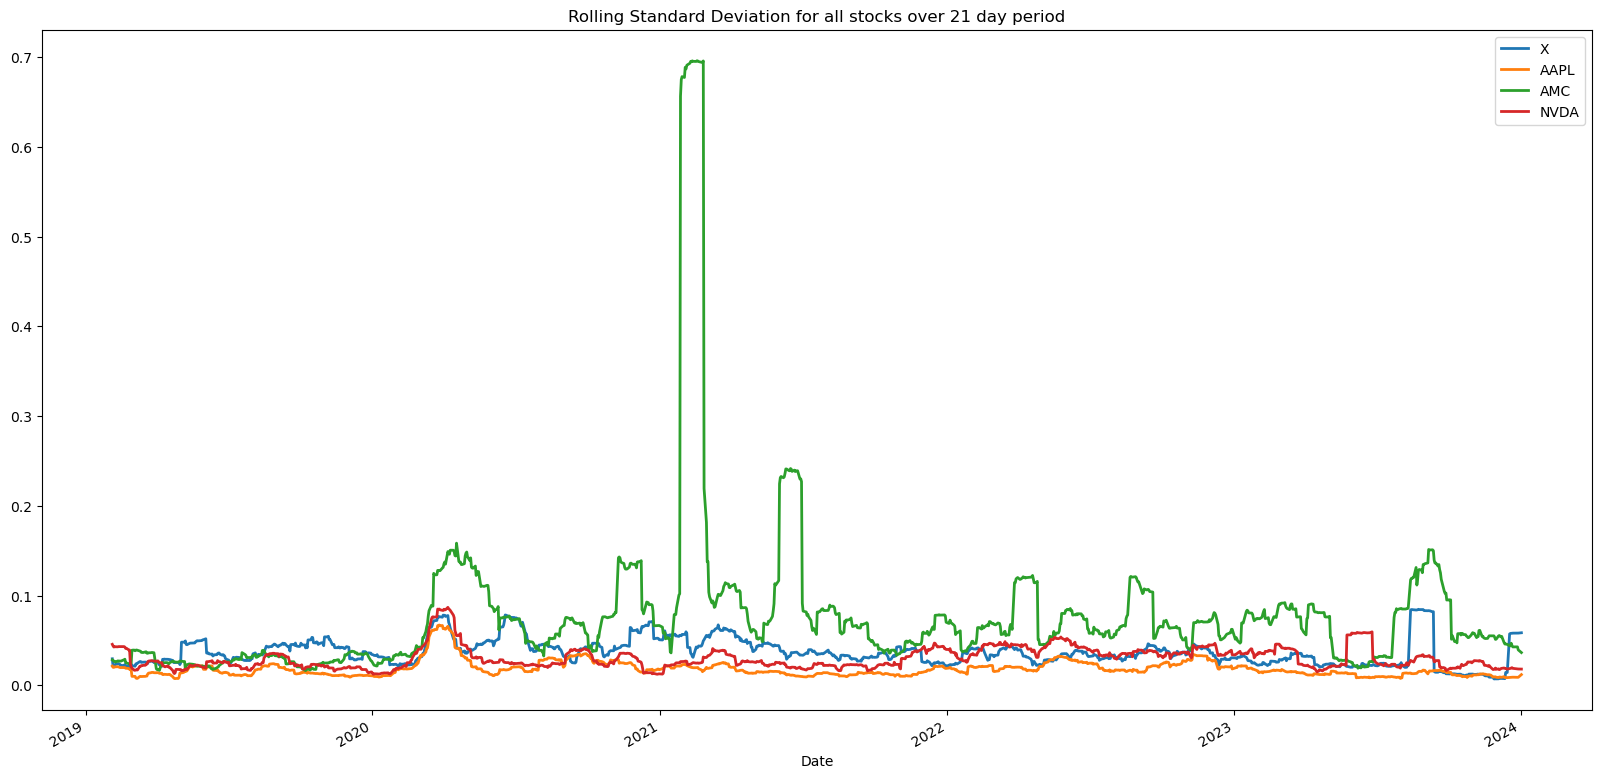

In [36]:
# Calculate the rolling standard deviation for all portfolios using a 21-day window
rolling_std = portfolio_returns.rolling(window=21).std()
#excess_rolling_std = excess_returns.rolling(window=90).std()

# Plot the rolling standard deviation
rolling_std.plot(figsize=(20,10), linewidth=2, title= 'Rolling Standard Deviation for all stocks over 21 day period')
plt.savefig('gui_images/standard_deviation.png')

# Plotting excess
#excess_rolling_std.plot(figsize=(20,10), title= 'Rolling Standard Deviation of excess returns for stocks over 90 day period')
#plt.savefig('gui_images/excess_return.png')

### Plotting and calculating the Sharpe ratio

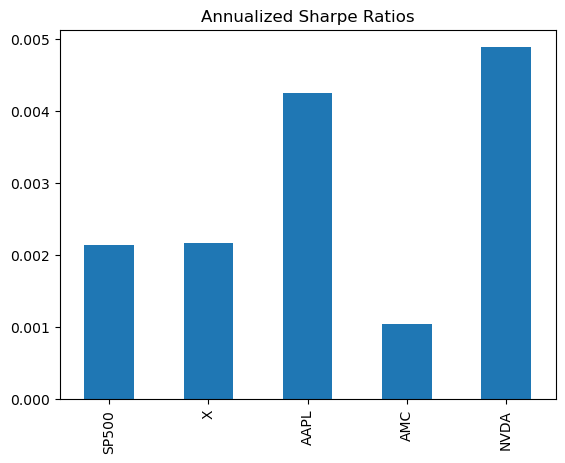

In [39]:
# Annualized Sharpe Ratios. Calculate sharpe ratio assuming risk free rate is 0.04
annualized_sharpe = ((combined_returns.mean() - risk_free_rate) / (combined_returns.std() * np.sqrt(252)))
# Visualize the sharpe ratios as a bar plot
annualized_sharpe.plot(kind='bar', 
                       title='Annualized Sharpe Ratios')
plt.savefig('gui_images/annualized_sharpe.png')

### Calculating and plotting the Correlation Matrix

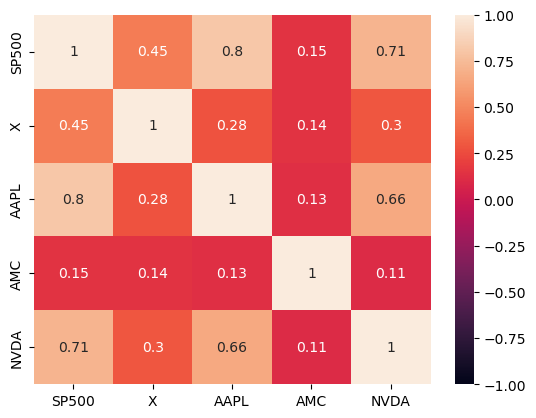

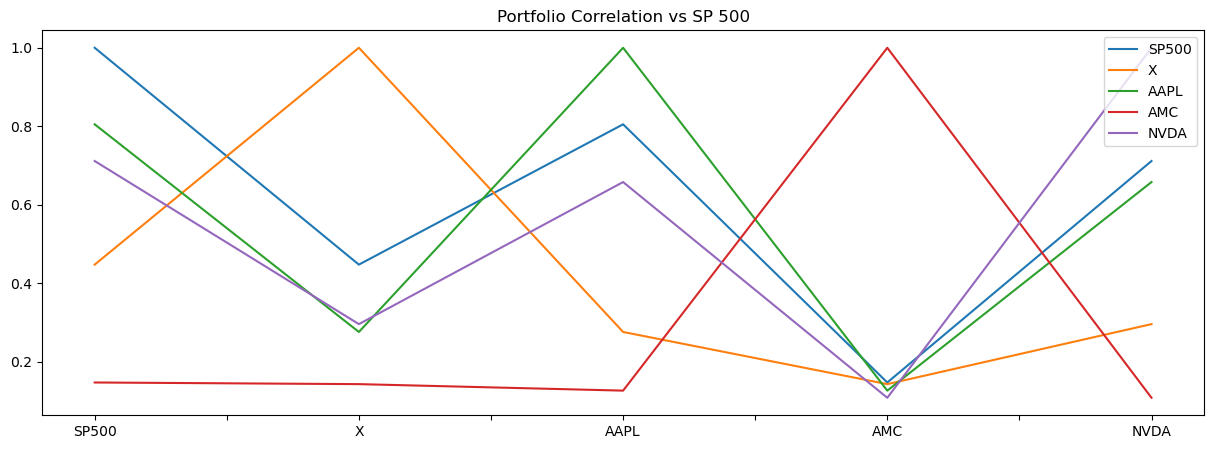

In [40]:
# Calculate the correlation
correlation_matrix = combined_returns.corr()
# Display de correlation matrix
sns.heatmap(correlation_matrix, vmin=-1, vmax=1, annot=True)
plt.savefig('gui_images/correlation_heatmap.png')

correlation_matrix.plot(figsize=(15,5), title='Portfolio Correlation vs SP 500')
plt.savefig('gui_images/portfolio_correlation.png')

In [41]:
# Calculate portflio weight
portfolio_weights = [(percentage / 100) for percentage in portfolio_summary['Percentage'].tolist()]

# Create empty disctionaty for portfolio data to save all downloaded data.
# Run "for" loop to iterate through each stock ticker in the list and 
# download all data in defined period of time.
portfolio_data = {}
for stock_symbol in portfolio_tickers:
    stock_data = yf.download(stock_symbol, period="5y")
    portfolio_data[stock_symbol] = stock_data


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [42]:
# Concatenate portfolio data, concatenate along the columns and asign keys for each stock
portfolio_data_df = pd.concat(portfolio_data.values(),  axis=1, keys=portfolio_data.keys())

# Change column names to upper case for tickers and lower case for definition
portfolio_data_df.columns = portfolio_data_df.columns.map(lambda x: (x[0].upper(), x[1].lower()))
portfolio_data_df

X                                                        \
                 open       high        low      close  adj close    volume   
Date                                                                          
2019-01-03  18.379999  18.920000  18.270000  18.480000  17.792543   8359100   
2019-01-04  18.840000  20.540001  18.780001  20.340000  19.583359  10737800   
2019-01-07  20.930000  21.000000  20.160000  20.450001  19.689266  12320700   
2019-01-08  20.570000  21.200001  20.360001  20.700001  19.929964   8463400   
2019-01-09  20.940001  21.000000  20.150000  20.840000  20.064754   9685600   
...               ...        ...        ...        ...        ...       ...   
2023-12-26  47.830002  48.430000  47.820000  48.349998  48.349998   4833400   
2023-12-27  48.299999  48.730000  48.290001  48.610001  48.610001   3281200   
2023-12-28  48.610001  48.840000  48.560001  48.660000  48.660000   3691700   
2023-12-29  48.660000  48.950001  48.639999  48.650002  48.650002   3616700   
2024-01-02  48.500000  48.599998  47.910000  47.959999  47.959999   5830499   

                  AAPL                                      ...         AMC  \
                  open        high         low       close  ...         low   
Date                                                        ...               
2019-01-03   35.994999   36.430000   35.500000   35.547501  ...  126.300003   
2019-01-04   36.132500   37.137501   35.950001   37.064999  ...  130.199997   
2019-01-07   37.174999   37.207500   36.474998   36.982498  ...  133.699997   
2019-01-08   37.389999   37.955002   37.130001   37.687500  ...  140.899994   
2019-01-09   37.822498   38.632500   37.407501   38.327499  ...  138.899994   
...                ...         ...         ...         ...  ...         ...   
2023-12-26  193.610001  193.889999  192.830002  193.050003  ...    5.960000   
2023-12-27  192.490005  193.500000  191.089996  193.149994  ...    6.040000   
2023-12-28  194.139999  194.660004  193.169998  193.580002  ...    6.140000   
2023-12-29  193.899994  194.399994  191.729996  192.529999  ...    6.060000   
2024-01-02  187.149994  188.440002  183.884995  185.639999  ...    6.010000   

                                                    NVDA              \
                 close   adj close    volume        open        high   
Date                                                                   
2019-01-03  130.600006  129.584259    139240   33.447498   33.790001   
2019-01-04  135.399994  134.346909    102500   32.735001   34.432499   
2019-01-07  141.199997  140.101822    111920   34.625000   36.222500   
2019-01-08  145.699997  144.566818    112270   36.672501   36.695000   
2019-01-09  139.500000  138.415039    144360   35.474998   36.122501   
...                ...         ...       ...         ...         ...   
2023-12-26    6.110000    6.110000  13107000  489.679993  496.000000   
2023-12-27    6.160000    6.160000  11129300  495.109985  496.799988   
2023-12-28    6.210000    6.210000  18490600  496.429993  498.839996   
2023-12-29    6.120000    6.120000  15062400  498.130005  499.970001   
2024-01-02    6.110000    6.110000  13018182  492.440002  492.950012   

                                                          
                   low       close   adj close    volume  
Date                                                      
2019-01-03   31.922501   31.997499   31.748959  70555200  
2019-01-04   32.424999   34.047501   33.783035  58562000  
2019-01-07   34.107498   35.849998   35.571526  70916000  
2019-01-08   34.224998   34.957500   34.685966  78601600  
2019-01-09   34.965000   35.645000   35.368130  61726000  
...                ...         ...         ...       ...  
2023-12-26  489.600006  492.790009  492.790009  24420000  
2023-12-27  490.850006  494.170013  494.170013  23364800  
2023-12-28  494.119995  495.220001  495.220001  24658700  
2023-12-29  487.510010  495.220001  495.220001  38869000  
2024-01-02  475.950012  481.67

## Monte Carlo Simulation running 500 simulations over a 10 year period

In [43]:
num_sims = 500

# Configuring a Monte Carlo simulation to forecast 10 years cumulative returns
MC_10years = MCSimulation(
    portfolio_data = portfolio_data_df,
    weights = portfolio_weights,
    num_simulation = num_sims,
    num_trading_days = 252*10
)

# Calculate daily return for portfolio and add name column 
MC_10years.portfolio_data.dropna()

X                                                        \
                 open       high        low      close  adj close    volume   
Date                                                                          
2019-01-04  18.840000  20.540001  18.780001  20.340000  19.583359  10737800   
2019-01-07  20.930000  21.000000  20.160000  20.450001  19.689266  12320700   
2019-01-08  20.570000  21.200001  20.360001  20.700001  19.929964   8463400   
2019-01-09  20.940001  21.000000  20.150000  20.840000  20.064754   9685600   
2019-01-10  20.590000  21.150000  20.420000  20.990000  20.209175   7419400   
...               ...        ...        ...        ...        ...       ...   
2023-12-26  47.830002  48.430000  47.820000  48.349998  48.349998   4833400   
2023-12-27  48.299999  48.730000  48.290001  48.610001  48.610001   3281200   
2023-12-28  48.610001  48.840000  48.560001  48.660000  48.660000   3691700   
2023-12-29  48.660000  48.950001  48.639999  48.650002  48.650002   3616700   
2024-01-02  48.500000  48.599998  47.910000  47.959999  47.959999   5830499   

                               AAPL                          ...         AMC  \
           daily_return        open        high         low  ...   adj close   
Date                                                         ...               
2019-01-04     0.100649   36.132500   37.137501   35.950001  ...  134.346909   
2019-01-07     0.005408   37.174999   37.207500   36.474998  ...  140.101822   
2019-01-08     0.012225   37.389999   37.955002   37.130001  ...  144.566818   
2019-01-09     0.006763   37.822498   38.632500   37.407501  ...  138.415039   
2019-01-10     0.007198   38.125000   38.492500   37.715000  ...  136.232147   
...                 ...         ...         ...         ...  ...         ...   
2023-12-26     0.007922  193.610001  193.889999  192.830002  ...    6.110000   
2023-12-27     0.005378  192.490005  193.500000  191.089996  ...    6.160000   
2023-12-28     0.001029  194.139999  194.660004  193.169998  ...    6.210000   
2023-12-29    -0.000205  193.899994  194.399994  191.729996  ...    6.120000   
2024-01-02    -0.014183  187.149994  188.440002  183.884995  ...    6.110000   

                                         NVDA                          \
              volume daily_return        open        high         low   
Date                                                                    
2019-01-04    102500     0.036753   32.735001   34.432499   32.424999   
2019-01-07    111920     0.042836   34.625000   36.222500   34.107498   
2019-01-08    112270     0.031870   36.672501   36.695000   34.224998   
2019-01-09    144360    -0.042553   35.474998   36.122501   34.965000   
2019-01-10     97650    -0.015771   35.450001   36.395000   34.840000   
...              ...          ...         ...         ...         ...   
2023-12-26  13107000     0.001639  489.679993  496.000000  489.600006   
2023-12-27  11129300     0.008183  495.109985  496.799988  490.850006   
2023-12-28  18490600     0.008117  496.429993  498.839996  494.119995   
2023-12-29  15062400    -0.014493  498.130005  499.970001  487.510010   
2024-01-02  13018182    -0.001634  492.440002  492.950012  475.950012   

                                                           
                 close   adj close    volume daily_return  
Date                                                       
2019-01-04   34.047501   33.783035  58562000     0.064068  
2019-01-07   35.849998   35.571526  70916000     0.052941  
2019-01-08   34.957500   34.685966  78601600    -0.024895  
2019-01-09   35.645000   35.368130  61726000     0.019667  
2019-01-10   36.307499   36.025475  52315600     0.018586  
...                ...         ...       ...          ...  
2023-12-26  492.790009  492.790009  24420000     0.009195  
2023-12-27  494.170013  494.170013  23364800     0.002800  
2023-12-28  495.220001  495.220001  24658700     0.002125  
2023-12-29  495.220001  495.220001  38869000     

In [44]:
# Run monte carlo simulation
MC_10years.calc_cumulative_return()

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.
Running Monte Carlo simulation number 110.
Running Monte Carlo simulation number 120.
Running Monte Carlo simulation number 130.
Running Monte Carlo simulation number 140.
Running Monte Carlo simulation number 150.
Running Monte Carlo simulation number 160.
Running Monte Carlo simulation number 170.
Running Monte Carlo simulation number 180.
Running Monte Carlo simulation number 190.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 210.
Running Monte Carlo simulation number 220.
Running Monte Carlo si

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,0.995994,0.989651,0.993555,0.976209,1.023479,1.047278,1.005925,0.982555,1.001667,0.976279,...,0.986225,0.983894,0.977318,1.011108,0.955236,0.985213,1.008287,1.049549,0.999377,0.980813
2,1.024043,1.007411,1.013032,0.990287,1.016952,1.052870,1.025807,0.989583,1.004092,0.971968,...,0.960442,0.985621,0.996744,1.018559,0.957682,0.942504,0.999499,1.052468,1.002369,0.975459
3,1.036676,1.025847,1.068887,1.020118,1.003672,1.017598,1.033458,1.032611,1.010209,1.002628,...,0.944250,1.008238,0.995401,0.997412,0.979681,0.919791,1.005434,1.043833,0.974741,0.994002
4,1.058222,0.999520,1.080436,1.050826,1.001752,1.013363,1.046196,1.057726,0.998826,1.002507,...,0.951397,0.998480,0.990692,1.043565,0.978325,0.944003,1.007103,1.064822,0.983204,0.967502
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2516,40.838149,457.269652,178.278700,670.521768,119.820840,168.428267,97.076914,194.295966,127.942704,76.719674,...,1616.986778,566.808586,599.057872,51.059449,436.122520,258.098421,64.452277,194.192547,216.919725,113.657406
2517,40.756069,460.871495,183.542264,673.857006,117.687730,171.270107,96.364998,197.737455,125.950385,74.490894,...,1659.146715,558.106194,578.503859,52.367711,448.211715,262.835256,62.172021,200.090657,225.485749,111.435651
2518,41.251340,471.177557,176.435751,672.656627,119.705948,176.545599,99.940053,196.881818,123.715563,76.597163,...,1642.809738,560.530849,563.442248,52.011078,438.802006,268.177531,61.053403,206.450493,229.338014,112.233936
2519,41.370396,477.539528,175.185852,674.964421,123.498425,174.867076,99.028578,197.188628,119.661624,78.637618,...,1689.415528,554.050871,583.514684,53.210654,444.500938,262.056130,61.106747,210.105445,234.643176,115.823192


### Plotting the outcomes of the 500 simulations

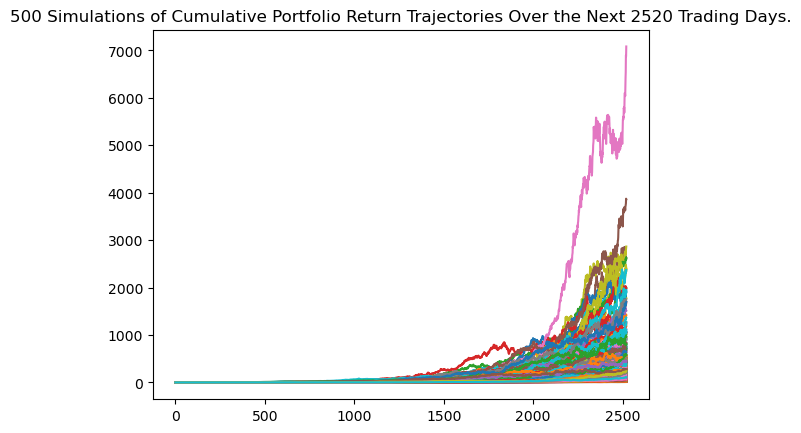

In [45]:
# Plot simulation outcomes 
line_plot = MC_10years.plot_simulation()

# Save the plot for future usage
line_plot.get_figure().savefig("gui_images/Monte_Carlo_10_year", bbox_inches="tight")

### Plotting the probability of distribution

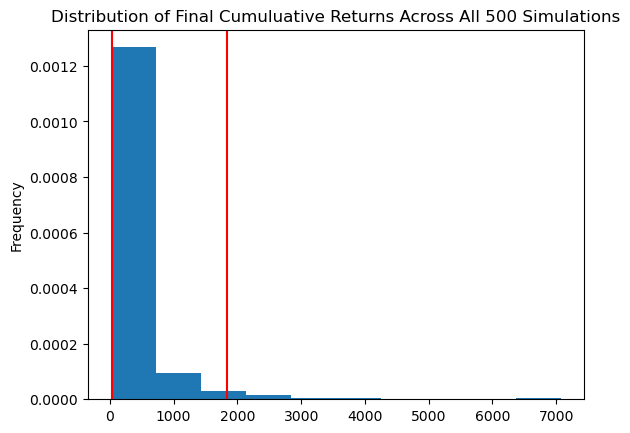

In [46]:
# Plot probability distribution and confidence intervals
distribution_plot = MC_10years.plot_distribution()

# Save the plot for future usage
distribution_plot.get_figure().savefig('gui_images/Monte_Carlo_10year_dist_plot.png',bbox_inches='tight')

## Summary of the outcome of the Monte Carlo simulation 
The high and low end of what could happen within 10 years with the current portfolio

In [47]:
# Fetch summary statistics from the Monte Carlo simulation results
MC_summary = MC_10years.summarize_cumulative_return()

# Set initial investment
initial_investment_10year = total_portfolio_value

# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes.
ci_lower_ten = round(MC_summary[8] * initial_investment_10year,2)
ci_upper_ten = round(MC_summary[9] * initial_investment_10year,2)
ci_average_ten = round((ci_lower_ten + ci_upper_ten)/2,2)




# Calculate annual return and annual percetage return on average.
annual_lower_return_10 = ((ci_lower_ten - initial_investment_10year) / 10)
annual_lower_percent_10 = annual_lower_return_10 / initial_investment_10year


annual_upper_return_10 = ((ci_upper_ten - initial_investment_10year) / 10)
annual_upper_percent_10 = annual_upper_return_10 / initial_investment_10year





annual_average_return_10 = ((ci_average_ten - initial_investment_10year) / 10)
annual_average_percent_10 = annual_average_return_10 / initial_investment_10year





# Print results
print(f"There is a 95% chance that an initial investment of ${initial_investment_10year:.2f} in the portfolio"
      f" over the next 10 years will end within in the range of"
      f"\n${ci_lower_ten} (Lower Annual Percent Change for 10 years: {annual_lower_percent_10 * 100:.2f}%) and" 
      f"\n${ci_upper_ten} (Upper Annual Percent Change for 10 years: {annual_upper_percent_10 * 100:.2f}%)."
      f"\nOn average {ci_average_ten} (Average Annual Percent Change for 10 years: {annual_average_percent_10 * 100:.2f}%)")




There is a 95% chance that an initial investment of $8597.27 in the portfolio over the next 10 years will end within in the range of
$226937.93 (Lower Annual Percent Change for 10 years: 253.97%) and
$15839462.9 (Upper Annual Percent Change for 10 years: 18413.83%).
On average 8033200.42 (Average Annual Percent Change for 10 years: 9333.90%)
